<a href="https://colab.research.google.com/github/XiangxiangXu/NFE/blob/main/SEQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demo to learn dependence structure from sequential data.

In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [2]:
import numpy as np

delta = 2

#    s[i + delta] = np.mod(np.sum(s[i:i+delta]) + z, 2)

# 1st order Markov
def gen_s(L, p = .75):
    s = np.random.choice(2, size=L)
    for i in range(L-2):
        z = (np.random.rand() < p)
        s[i + 2] = np.mod(s[i + 1] + z, 2)
    return s

# 2nd order Markov
def gen_t(L, p = .75):
    t = np.random.choice(2, size=L)
    for i in range(L-2):
        z = (np.random.rand() > p)
        t[i + 2] = np.mod(t[i] + z, 2)
    return t

L = 12000
s = gen_s(L)
t = gen_t(L)

Plot two sequences.

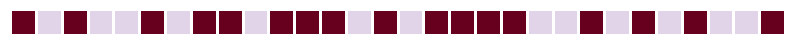

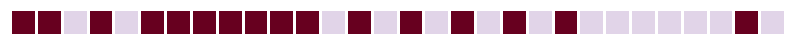

In [3]:
from matplotlib import pyplot as plt

plt.rcParams['image.cmap'] = 'PuRd'#'BuPu'#'YlOrRd'#YlGn'#Purples'

def plot_seq(seq):
    plt.figure(figsize = (10, 1))
    plt.pcolormesh(seq.reshape(1, -1), edgecolors='w', linewidth=1, vmin = -.2, vmax = 1) #.8)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.axis('off')

random_number = np.random.randint(0, L-100)
plot_seq(s[random_number:random_number+30])
plot_seq(t[random_number:random_number+30])



train on s or t

In [4]:
seq = t

#### or
# seq = s

In [5]:
x_card = 2
batchsize = 128

x3 = seq[::4]
x2 = seq[1::4]
x1 = seq[2::4]
x0 = seq[3::4]

import torch
import torch.nn.functional as F
tensorize = lambda x: torch.LongTensor(x)
onehot_bi_tensor = lambda x: F.one_hot(torch.tensor(x), 2).type(torch.FloatTensor)
X0, X1, X2, X3 = map(tensorize, [x0, x1, x2, x3])


from torch.utils.data import TensorDataset, DataLoader

# dataloder for training
ds = TensorDataset(X0, X1, X2, X3)
dl = DataLoader(ds, batch_size=batchsize, shuffle = True)

### Packaging the Sub-Networks



In [6]:
from torch import nn, optim

class fc_net(nn.Module): # fully connected
    def __init__(self, fdim, num_classes):
        super().__init__()
        self.fc = nn.Linear(num_classes, fdim)

    def forward(self, x):
        f = self.fc(x)
        return f




class fg_nn_seq(nn.Module):
    def __init__(self, f_net, g_net_list):
        # f_net: output a list of outputs
        # g_nets_list: a list of nn.Modules
        super().__init__()
        self.f_net = f_net
        self.g_net_list = g_net_list

    def forward(self, x_history, x0):
        # x_history = x[-1], x[-2], ...
        f = self.f_net(x_history)
        len_history = x_history.shape[1]
        f_list = [f[:, i, :] for i in range(len_history)]
        g_list = [g(x0) for g in self.g_net_list]
        return f_list, g_list


class enc_history(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, num_layers, len_history, embedding = True, batch_first = True):
        super().__init__()
        self.len_history = len_history
        if embedding:
            self.emb_list = [nn.Embedding(card, d_model) for i in range(len_history)]
        self.enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=batch_first)
        self.enc = nn.TransformerEncoder(self.enc_layer, num_layers=num_layers)

    def forward(self, x_history):
        emb_list = [self.emb_list[i](x_history[:, i]) for i in range(self.len_history)]
        emb_res = torch.stack(emb_list, axis = 1)
        attn_mask = nn.Transformer.generate_square_subsequent_mask(self.len_history)
        return self.enc(emb_res, mask = attn_mask, is_causal=True)

In [7]:
card = 2
k = 8
len_history = 3

In [8]:


enc_hist = enc_history(d_model = k, nhead = 1, dim_feedforward = 8, num_layers = 3, len_history = 3)
model = fg_nn_seq(enc_hist, [nn.Embedding(card, k) for i in range(len_history)])#[g1_net, g2_net, g3_net])

opt = optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


H-score computation

In [9]:
centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / x.size()[0] # covariance

def get_info(f, g):
    cov_f = cov(f)
    cov_g = cov(g)
    return torch.trace(cov_f @ cov_g)

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    info = get_info(f, g)
    return - corr + info / 2.


def neg_hscore_seq(f_list, g_list):
    """
    compute the (nagative) H-score for seq:

    from dim 0
    """
    terms = len(f_list)
    # batchsize x seq_len x dim

    res = 0
    for i in range(terms):
        f = torch.cat(f_list[:i+1], axis = 1)
        g = torch.cat(g_list[:i+1], axis = 1)
        res += neg_hscore(f, g)
    return res


nEpochs = 100

from tqdm import tqdm
for epoch in tqdm(range(nEpochs)):
    # if epoch % 10 == 0:
    #     print("Epoch " + str(epoch) + '/' + str(nEpochs))
    for x0, x1, x2, x3 in dl:
        x_history = torch.stack([x1, x2, x3], axis = 1)
        #x_history = torch.cat([x1, x2, x3], axis = 1)
        f_list, g_list = model(x_history.to(device), x0.to(device)) #x1.to(device), x2.to(device), x3.to(device)
        loss = neg_hscore_seq(f_list, g_list)
        loss.backward()
        opt.step()
        opt.zero_grad()

100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


Compute features on the training set.

In [10]:
f_train_list, g_train_list = model(torch.stack([X1, X2, X3], axis = 1).to(device), X0.to(device))

Plot the depndence spectrum.

tensor([0.0051, 0.2435, 0.0195])


<StemContainer object of 3 artists>

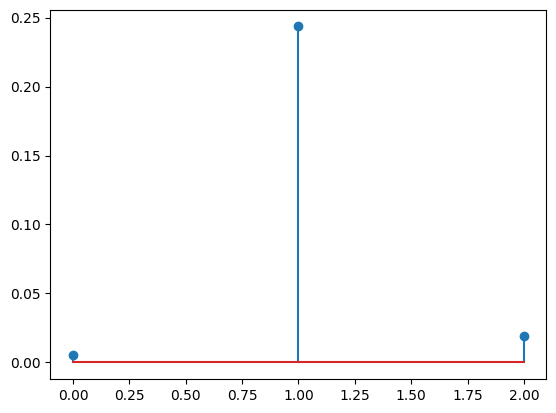

In [11]:

spec = torch.tensor([get_info(f_train_list[i], g_train_list[i]) for i in range(len(f_list))])
print(spec)

detach = lambda x: x.cpu().detach().numpy()

import matplotlib.pyplot as plt
plt.stem(detach(spec))




## Old Implementation
Fully connected nets.

In [12]:



# f1_train = model.f1_net(X1)
# f2_train = model.f2_net([X1, X2])
# f3_train = model.f3_net([X1, X2, X3])
# g1_train = model.g1_net(X0)
# g2_train = model.g2_net(X0)
# g3_train = model.g3_net(X0)

# info1 = get_info(f1_train, g1_train)
# info2 = get_info(f2_train, g2_train)
# info3 = get_info(f3_train, g3_train)

kron2 = lambda x1, x2: torch.stack([torch.kron(x1[i], x2[i]) for i in range(len(x1))])

class fc_net_kron(nn.Module):
    # fully connected, with kronecker product of two variables as the input
    def __init__(self, fdim, num_classes):
        super().__init__()
        self.fc = nn.Linear(num_classes, fdim)

    def forward(self, x12):
        x1, x2 = x12
        x1x2 = kron2(x1, x2)
        # row-wise kronecker product:
        #     to convert (x1, x2) into x1 * x2_card + x2
        f = self.fc(x1x2)
        return f

class fc_net_kron3(nn.Module):
    # fully connected, with kronecker product of three variables as the input
    def __init__(self, fdim, num_classes):
        super().__init__()
        self.fc = nn.Linear(num_classes, fdim)

    def forward(self, x123):
        x1, x2, x3 = x123
        x1x2x3 = kron2(kron2(x1, x2), x3)
        # row-wise kronecker product:
        #     to convert (x1, x2, x3) into x1 * x2_card * x3_card + x2 * x3_card + x3
        f = self.fc(x1x2x3)
        return f

# below is a special case up to 3rd order:
class fg_nn_seq_3(nn.Module):
    # 3rd order
    def __init__(self, f_nets, g_nets):
        super().__init__()
        self.f1_net, self.f2_net, self.f3_net = f_nets
        self.g1_net, self.g2_net, self.g3_net = g_nets

    def forward(self, x0, x1, x2, x3):
        f1 = self.f1_net(x1)
        f2 = self.f2_net([x1, x2])
        f3 = self.f3_net([x1, x2, x3])
        g1 = self.g1_net(x0)
        g2 = self.g2_net(x0)
        g3 = self.g3_net(x0)
        return [f1, f2, f3], [g1, g2, g3]

k1 = 4
k2 = 4
k3 = 4
f1_net = fc_net(k1, x_card)
f2_net = fc_net_kron(k2, x_card ** 2)
f3_net = fc_net_kron3(k3, x_card ** 3)
g1_net = fc_net(k1, x_card)
g2_net = fc_net(k2, x_card)
g3_net = fc_net(k3, x_card)


#model = fg_nn_seq_3([f1_net, f2_net, f3_net], [g1_net, g2_net, g3_net])

def neg_hscore_seq_3(f_list, g_list):
    f1, f2, f3 = f_list
    g1, g2, g3 = g_list
    f12 = torch.cat([f1, f2], axis = 1)
    g12 = torch.cat([g1, g2], axis = 1)
    f123 = torch.cat(f_list, axis = 1)
    g123 = torch.cat(g_list, axis = 1)
    res = neg_hscore(f1, g1) + neg_hscore(f12, g12) + neg_hscore(f123, g123)
    return res

